In [1]:
import numpy as np
import pandas as pd
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import psycopg2
from sqlalchemy import create_engine
import os
import plotly.figure_factory as ff
import plotly.express as px
POSTGRES_PASSWORD = os.getenv('POSTGRES_PASSWORD')

In [2]:
engine = create_engine('postgresql+psycopg2://{user}:{password}@{host}:{port}/{db}'.format(
    user = 'postgres',
    password = POSTGRES_PASSWORD,
    host = 'postgres',
    port = 5432,
    db = 'congress'
))

In [3]:
myquery = '''
SELECT directordername, bioguideid
FROM members
ORDER BY lastname
'''
members = pd.read_sql_query(myquery, con = engine)
member_list = [{'label': x, 'value': y} for x, y in zip(members['directordername'], members['bioguideid'])]

In [4]:
# senators don't have districts, we can take advantage of that
myquery = '''
SELECT bioguideid,
    directordername,
    party,
    ideology,
    state,
    district
FROM members
'''
ideo_df = pd.read_sql_query(myquery, con = engine)
# chamber == True if senator
ideo_df['chamber'] = ideo_df['district'].isnull()
ideo_df['chamber'] = ideo_df['chamber'].replace({True: 'Senate', False: 
                                      'House of Representatives'})
ideo_df

,bioguideid,directordername,party,ideology,state,district,chamber
0,B000944,Sherrod Brown,D,-0.427,Ohio,NaN,Senate
1,C000127,Maria Cantwell,D,-0.305,Washington,NaN,Senate
2,C000141,Benjamin L. Cardin,D,-0.320,Maryland,NaN,Senate
3,C000174,Thomas R. Carper,D,-0.178,Delaware,NaN,Senate
4,C001070,Robert P. Casey Jr.,D,-0.313,Pennsylvania,NaN,Senate
...,...,...,...,...,...,...,...
525,G000600,Marie Gluesenkamp Perez,D,-0.115,Washington,3.0,House of Representatives
526,V000135,Derrick Van Orden,R,0.381,Wisconsin,3.0,House of Representatives
527,H001096,Harriet M. Hageman,R,0.688,Wyoming,NaN,Senate
528,R000618,Pete Ricketts,R,0.369,Nebraska,NaN,Senate


In [5]:
# getting the full info
ideo_df['namedistrict'] = [n + ' (' + s + ')'  if c == 'Senate' 
     else n + ' (' + s + '-' + str(int(d)) + ')' 
 for n,s,c,d in zip(ideo_df['directordername'], ideo_df['state'], ideo_df['chamber'], ideo_df['district'])]
ideo_df['party'] = ideo_df['party'].replace({'D': 'Democrat',
                                            'I': 'Independent',
                                            'R': 'Republican'})

# example query for the star
userbioguideid = 'G000595'
ideo2 = ideo_df.query(f"bioguideid == '{userbioguideid}'")

In [6]:
ideo_df

,bioguideid,directordername,party,ideology,state,district,chamber,namedistrict
0,B000944,Sherrod Brown,Democrat,-0.427,Ohio,NaN,Senate,Sherrod Brown (Ohio)
1,C000127,Maria Cantwell,Democrat,-0.305,Washington,NaN,Senate,Maria Cantwell (Washington)
2,C000141,Benjamin L. Cardin,Democrat,-0.320,Maryland,NaN,Senate,Benjamin L. Cardin (Maryland)
3,C000174,Thomas R. Carper,Democrat,-0.178,Delaware,NaN,Senate,Thomas R. Carper (Delaware)
4,C001070,Robert P. Casey Jr.,Democrat,-0.313,Pennsylvania,NaN,Senate,Robert P. Casey Jr. (Pennsylvania)
...,...,...,...,...,...,...,...,...
525,G000600,Marie Gluesenkamp Perez,Democrat,-0.115,Washington,3.0,House of Representatives,Marie Gluesenkamp Perez (Washington-3)
526,V000135,Derrick Van Orden,Republican,0.381,Wisconsin,3.0,House of Representatives,Derrick Van Orden (Wisconsin-3)
527,H001096,Harriet M. Hageman,Republican,0.688,Wyoming,NaN,Senate,Harriet M. Hageman (Wyoming)
528,R000618,Pete Ricketts,Republican,0.369,Nebraska,NaN,Senate,Pete Ricketts (Nebraska)


In [7]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

In [8]:
mymarkdown = '''
Congressional elections are usually all about the big, national issues. But, these Representatives and Senators work for local districts and states. Not all issues are the same everywhere. The purpose of this dashboard is to collect public data from these sources:

* [Official API for the U.S. Congress](https://api.congress.gov/)

* [Voteview](https://voteview.com/data)

* [Open Secrets](https://www.opensecrets.org/open-data/api)

* [ProPublica's Data on Bills](https://www.propublica.org/datastore/dataset/congressional-data-bulk-legislation-bills)
'''

In [45]:
# initialization step
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

# specification of what goes on
app.layout = html.Div(
    [
        # Stuff on Top
        html.H1("Know Your Representatives in Congress"),
        html.H2("Data collected from APIs from Congress.gov, Open Secrets, Voteview.com, and ProPublica"),
        html.H3("DS 6600: Data Engineering 1, UVA Data Science"),
        # Side Bar
        html.Div([
            dcc.Markdown('Please select a Representative or Senator:'),
            dcc.Dropdown(id = 'member', options = member_list,
                    value = 'A000370'),
            dcc.Markdown(mymarkdown)
        ], style = {'width': '24%', 'float': 'left'}),
        
        # Main
        html.Div([
            dcc.Tabs([
                dcc.Tab(label = 'Biographical Info', children = [
                    # stuff for bio tab goes here
                    html.Div([html.Img(id = 'bioimage', style={'height':'100%', 'width':'100%'})], style = {'width': '24%', 'float':'left'}),
                    html.Div([dcc.Graph(id = 'biotable')], style = {'width': '74%', 'float':'right'})
                ]),
                dcc.Tab(label = 'Bill Sponsorship', children = [
                    # stuff for Bill Sponsorhip tab goes here
                ]),
                dcc.Tab(label = 'Voting and Ideology', children = [
                    # stuff for Voting tab goes here
                    dcc.Graph(id = 'ideograph', style = {'height': '100%', 'width': '100%'}),
                    dcc.Markdown('Here are the top 10 most similar members of congress by voting record:'),
                    dcc.Graph(id = 'votesim')
                ]),
                dcc.Tab(label = 'Donors and Financial Info', children = [
                    # stuff for Donors tab goes here
                    dcc.Graph(id = 'money')
                ])
                
            ])
        ], style = {'width': '74%', 'float': 'right'})
    ]
)

@app.callback([Output(component_id = 'biotable', component_property = 'figure')],
             [Input(component_id = 'member', component_property = 'value')])

def BioTable(b):
    myquery = f'''
    SELECT directordername AS Name, 
            party AS Party,
            state AS State,
            CAST(district AS int) AS District,
            birthyear AS Birthyear,
            addressinformation_officeaddress AS Address,
            CONCAT(addressinformation_city, ', ', addressinformation_district) AS City,
            addressinformation_zipcode AS Zipcode,
            addressinformation_phonenumber AS Phone
    FROM members
    WHERE bioguideid = '{b}'
    '''
    
    mydf = pd.read_sql_query(myquery, con = engine)
    
    mydf.columns = [x.capitalize() for x in mydf.columns]
    
    mydf = mydf.T.reset_index()
    
    mydf = mydf.rename({'index': '', 0:''}, axis = 1)
    
    return [ff.create_table(mydf)]

@app.callback([Output(component_id = 'bioimage', component_property = 'src')],
             [Input(component_id = 'member', component_property = 'value')])

def bioimage(b):
    myquery = f'''
    SELECT depiction_imageurl
    FROM members
    WHERE bioguideid='{b}'
    '''
    mydf = pd.read_sql_query(myquery, con=engine)
    return [mydf['depiction_imageurl'][0]]

@app.callback([Output(component_id = 'ideograph', component_property = 'figure')],
             [Input(component_id = 'member', component_property = 'value')])

def ideograph(b):
    ideo2 = ideo_df.query(f"bioguideid == '{b}'")
    fig = px.scatter(ideo_df, x='ideology', y='chamber', color='party',
                     color_discrete_map={'Republican': 'red',
                                         'Democrat': 'blue',
                                         'Independent': 'green'},
                     height=300, width=600,
                     labels={'ideology':'Left/Right Ideology (DW-NOMINATE)', 
                            'chamber':'Chamber',
                            'party': 'Political Party'},
                     hover_name = 'namedistrict',
                     hover_data=['party'],
                     title = 'Ideological Placements in Congress',
                    opacity = .1)
    fig.update(layout=dict(title=dict(x=0.5)))
    fig.update_yaxes(range=(-0.5, 1.5), tickvals=[0, 1],
                    ticktext = ['Senate', 'House of Representatives'])
    fig.update_xaxes(range=(-1,1), tickvals=[-1, -.5, 0, .5, 1],
                    ticktext = ['Extreme left', 'Moderate left', 'Centrist', 'Moderate right', 'Extreme right'])
    
     
    
    fig.add_traces(
        px.scatter(ideo2, x='ideology', y='chamber', color='party',
                     color_discrete_map={'Republican': 'red',
                                         'Democrat': 'blue',
                                         'Independent': 'green'},
                     height=300, width=600,
                     labels={'ideology':'Left/Right Ideology (DW-NOMINATE)', 
                            'chamber':'Chamber',
                            'party': 'Political Party'},
                     hover_name = 'namedistrict',
                     hover_data=['party'],
                     title = 'Ideological Placements in Congress').update_traces(marker=dict(size=8, symbol="star", line=dict(width=2, color="DarkSlateGrey")),
                                                                                 showlegend=False).data
    )
    
    fig.update_layout(autosize=True)
    
    return [fig]

@app.callback([Output(component_id = 'votesim', component_property = 'figure')],
             [Input(component_id = 'member', component_property = 'value')])

def votesim(b):
    myquery = f'''
    SELECT m.directordername, 
        m.state,
        m.party,
        g.affinity_score
    FROM members m
    INNER JOIN (SELECT v.member_compare,
                    v.affinity_score
                FROM members m
                INNER JOIN votesim v
                    ON m.icpsr = v.icpsr
                WHERE m.bioguideid = '{b}'
                ORDER BY v.affinity_score
                    DESC
                LIMIT 10) g
        ON m.icpsr = g.member_compare
    ORDER BY g.affinity_score
        DESC
    '''
    vote_df = pd.read_sql_query(myquery, con = engine)
    vote_df = vote_df.rename({'directordername': 'Name',
                               'state': 'State',
                               'party': 'Party',
                               'affinity_score': 'Vote Similarity'}, axis = 1)
    vote_df['Vote Similarity'] = round(100 * vote_df['Vote Similarity'], 1).astype('str') + '%'
    return [ff.create_table(vote_df)]

@app.callback([Output(component_id = 'money', component_property = 'figure')],
             [Input(component_id = 'member', component_property = 'value')])

def contribgraph(b):
    myquery = f'''
    SELECT m.directordername,
        c.org_name,
        c.pac,
        c.ndiv
    FROM contributions c
    INNER JOIN members m
        ON m.cid = c.cid
    WHERE m.bioguideid = '{b}'
    '''
    contrib_df = pd.read_sql_query(myquery, con=engine)
    name = contrib_df['directordername'][0]
    contrib_df = contrib_df.drop('directordername', axis = 1) 
    contrib_df = contrib_df.rename({'org_name': 'Orginization',
                                   'pac': 'Contribution Via PAC',
                                   'ndiv': 'Direct Contrbiution'}, axis = 1)
    contrib_df = pd.melt(contrib_df, id_vars = ['Orginization'],
                        value_vars = ['Contribution Via PAC', 'Direct Contrbiution'])
    fig = px.bar(contrib_df, x = 'value', y = 'Orginization', color = 'variable', 
                 labels = {'value': 'Amount Donated', 'variable': 'Source'},
                title = f"Who's giving money to {name}?")
    fig.update(layout=dict(title=dict(x=0.5)))
    
    return [fig]

# exectuation
if __name__ == "__main__":
    app.run_server(mode="external", host = '0.0.0.0', port = '8050', debug = True)

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
File /usr/local/lib/python3.11/site-packages/pandas/core/indexes/range.py:345, in RangeIndex.get_loc(
    self=RangeIndex(start=0, stop=0, step=1),
    key=0
)
    344 try:
--> 345     return self._range.index(new_key)
        new_key = 0
        self = RangeIndex(start=0, stop=0, step=1)
        self._range = range(0, 0)
    346 except ValueError as err:

ValueError: 0 is not in range

The above exception was the direct cause of the following exception:

KeyError                                  Traceback (most recent call last)
KeyError: 0

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
File /usr/local/lib/python3.11/site-packages/pandas/core/indexes/range.py:345, in RangeIndex.get_loc(
    self=RangeIndex(start=0, stop=0, step=1),

In [19]:
# show who is most similar to that person
# 
b = 'G000386'
myquery = f'''
SELECT v.member_compare,
    v.affinity_score
FROM members m
INNER JOIN votesim v
    ON m.icpsr = v.icpsr
WHERE m.bioguideid = '{b}'
ORDER BY v.affinity_score
    DESC
LIMIT 10
'''
pd.read_sql_query(myquery, con = engine)

,member_compare,affinity_score
0,40305,0.856618
1,21133,0.841912
2,29754,0.838235
3,20146,0.838235
4,20101,0.834559
5,41902,0.827206
6,41505,0.823529
7,29534,0.823529
8,41302,0.816176
9,41502,0.816176


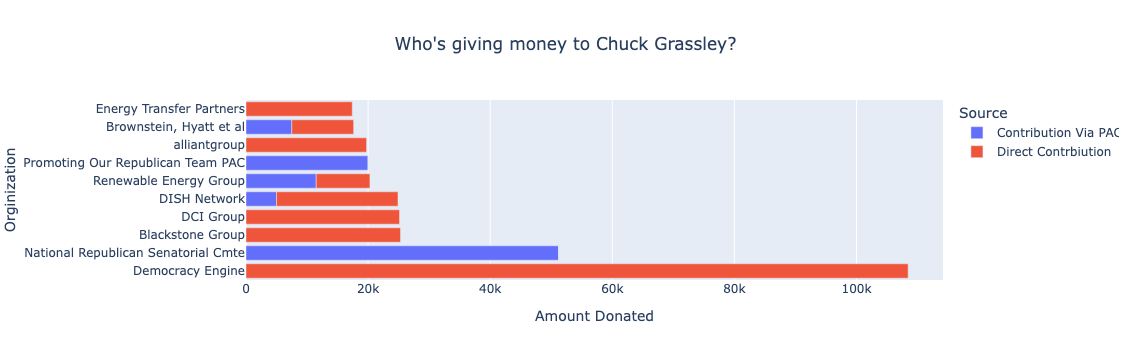

In [44]:
b = 'G000386'
myquery = f'''
SELECT m.directordername,
    c.org_name,
    c.pac,
    c.ndiv
FROM contributions c
INNER JOIN members m
    ON m.cid = c.cid
WHERE m.bioguideid = '{b}'
'''
contrib_df = pd.read_sql_query(myquery, con=engine)
name = contrib_df['directordername'][0]
contrib_df = contrib_df.drop('directordername', axis = 1) 
contrib_df = contrib_df.rename({'org_name': 'Orginization',
                               'pac': 'Contribution Via PAC',
                               'ndiv': 'Direct Contrbiution'}, axis = 1)
contrib_df = pd.melt(contrib_df, id_vars = ['Orginization'],
                    value_vars = ['Contribution Via PAC', 'Direct Contrbiution'])
fig = px.bar(contrib_df, x = 'value', y = 'Orginization', color = 'variable', 
             labels = {'value': 'Amount Donated', 'variable': 'Source'},
            title = f"Who's giving money to {name}?")
fig.update(layout=dict(title=dict(x=0.5)))
fig.show()